<a href="https://colab.research.google.com/github/Chang365/ESAA-25-1-assignments/blob/main/ESAA_25_2_1117_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <딥러닝 파이토치 교과서> 5장 p.179-200

## 5.2 합성곱 신경망 맛보기

fashion_mnist 데이터셋

-> torch vision에 내장된 예제 데이터

In [ ]:
# 5-1: 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [ ]:
# 5-2: CPU 혹은 GPU 장치 확인

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 5-3 fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST('./data',download=True,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./data',download=True,transform=transforms.Compose([transforms.ToTensor()]))
# 앞에서 훈련 데이터셋을 내려받았다면 여기에서는 테스트 데이터셋을 내려받는다.

In [ ]:
# 5-4: fashion_mnist 데이터를 데이터로드에 전달
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100)

- torch.utils data.DataLoader(): 순서가 무작위로 섞이도록 할 수 있음


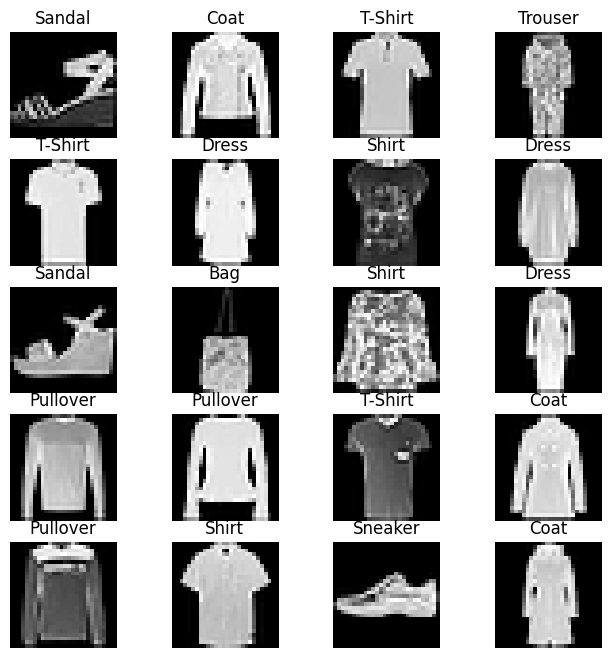

In [ ]:
# 5-5: 분류에 사용될 클래스 정의
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'} # 열 개의 클래스

fig = plt.figure(figsize=(8,8)); # 출력할 이미지의 가로세로 길이 단위는 inch
columns = 4;
rows = 5;
for i in range(1,columns*rows+1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows,columns,i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img,cmap='gray')
plt.show() # 20개의 이미지 데이터를 시각적으로 표현

합성곱 신경망과 합성곱 신경망이 아닌 층 망의 비교를 위해 먼저 심층 신경망을 생성한 후 학습

In [ ]:
# 5-6: 심층 신경망 모델 생성

class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN,self).__init__()
    self.fc1 = nn.Linear(in_features=784,out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256,out_features=128)
    self.fc3 = nn.Linear(in_features=128,out_features=10)

  def forward(self,input_data):
    out = input_data.view(-1,784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

1. 클래스 형태의 모델은 항상 torch.nn.Module을 상속 받음. __init__()은 객체가 갖는 속성 값을 초기화하는 역할을 하며 객체가 생성될 때 자동으로 호출됨

2. nn은 딥러닝 모델 구성에 필요한 모듈이 모여있는 패키지이며, Linear는 단순 선형 회귀 모델을 만들 때 사용

- in_features: 입력의 크기
- out_features: 출력의 크기

3. torch.nn.Dropout(p)는 p만큼의 비율로 텐서 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커짐.

4. forward() 함수는 모델이 학습 데이터를 입력받아서 순전파 학습을 진행시키며 반드시 forward 라는 이름의 함수여야 함

5. 파이토치에서 사용하는 뷰는 텐서의 크기를 변경해주는 역할을 함

6. 활성화 함수를 지정할 때는 다음 두 가지 방법이 가능

- F.relu(): foward() 함수에서 정의
- nn.ReLU(): __init__() 함수에서 정의

-> 차이는 사용하는 위치




In [ ]:
# 5-7: 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


- 옵티마이저를 위한 경사 하강법은 Adam을 사용하며 학습률을 의미하는 lr은 0.001 사용




In [ ]:
# 5-8: 심층 신경망을 이용한 모델 학습

num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images,labels in train_loader:
    images,labels=images.to(device),labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train) # 학습 데이터를 모델에 적용
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count%50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images,labels in test_loader:
        images,lables = images.to(device),labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs,1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct *100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,loss.data,accuracy))

Iteration: 500, Loss: 0.616997241973877, Accuracy: 84.73833465576172%
Iteration: 1000, Loss: 0.4838649034500122, Accuracy: 85.92666625976562%
Iteration: 1500, Loss: 0.3490857779979706, Accuracy: 86.55500030517578%
Iteration: 2000, Loss: 0.3454054594039917, Accuracy: 87.12666320800781%
Iteration: 2500, Loss: 0.267632395029068, Accuracy: 87.80999755859375%
Iteration: 3000, Loss: 0.2682420611381531, Accuracy: 88.69666290283203%


정확도가 86%로 높은 수치를 보여줌



In [ ]:
# 5-9: 합성곱 네트워크 생성

class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6,out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600,out_features=120)
    self.fc3 = nn.Linear(in_features=120,out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return(out)

1. nn.Sequential 을 사용하면 __ ini t __ ()에서 사용할 네트워크 모델들을 정의해 줄 뿐만 아니라, forward() 함수에서 구현될 순전파를 계층형태로 좀 더 가독성이 뛰어난 코드로 작성

2. 합성곱층은 합성곱 연산을 통해서 이미지의 특징을 추출함

    - in_channels
    - out_channels
    - kernel_size
    - padding
3. BatchN orm2d는 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것을 의미

4. MaxPoo12d는 이미지 크기를 축소시키는 용도로 사용

   - kernel_size
   - stide
5. Conv2d에서 사용하는 하이퍼파라미터 값들에 따라 출력 크기가 달라짐

   - in_features
   - out_features
   





In [14]:
# 5-10 합성곱 네트워크를 위한 파라미터 정의

learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
# 5-11: 모델 학습 및 성능 평가

num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images,labels in train_loader:
    images,labels=images.to(device),labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train) # 학습 데이터를 모델에 적용
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count%50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images,labels in test_loader:
        images,lables = images.to(device),labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs,1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct *100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,loss.data,accuracy))

심층 신경망과 비교하여 정확도가 약간 높음

실제로 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 생성할 수 있도록 학습해야함